In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv
/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


In [2]:
X_TRAIN = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
X_TEST = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
X_ORIG = pd.read_csv('/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv')



In [3]:
X_TRAIN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [4]:
X_TRAIN['cb_person_default_on_file'] = X_TRAIN['cb_person_default_on_file'].map({'Y': 1, 'N': 0})

X_TEST['cb_person_default_on_file'] = X_TEST['cb_person_default_on_file'].map({'Y': 1, 'N': 0})

In [5]:
## Loan status on Age over 40
df = X_TRAIN   
average_below_50 = df[df['person_age'] < 50]['loan_status'].mean()
average_above_50 = df[df['person_age'] >= 50]['loan_status'].mean()

print(f"Average loan status for people below 50: {average_below_50}")
print(f"Average loan status for people above 50: {average_above_50}")

## Approval chances increases slightly with age
df[df['person_age'] >= 40]['loan_status'].count()

Average loan status for people below 50: 0.14190771349862258
Average loan status for people above 50: 0.1911504424778761


2884

In [6]:
average_rates = df.groupby('loan_grade')['loan_int_rate'].mean()
print(average_rates)

## interest rates rises fastly with loan grades

loan_grade
A     7.335176
B    11.034733
C    13.510343
D    15.404599
E    16.930961
F    18.610940
G    20.327576
Name: loan_int_rate, dtype: float64


In [7]:
average_rates = df.groupby('loan_grade')['loan_status'].mean()
print(average_rates)

## chances of approval also increases with loan grade
## Should be because higher interest rates would cover for higher default rates

loan_grade
A    0.049180
B    0.102304
C    0.135375
D    0.593564
E    0.625372
F    0.610738
G    0.818182
Name: loan_status, dtype: float64


In [8]:
df['loan_grade'].value_counts()

# If loan grade is something customer applies for, everyone has very good chances from D
# grade loans

loan_grade
A    20984
B    20400
C    11036
D     5034
E     1009
F      149
G       33
Name: count, dtype: int64

In [9]:
# Let us check for the qualities of grade A loan approved people
df_A_grade = df[(df['loan_grade']=='A') & (df['loan_status']==1)] 
df_A_grade.shape
# There are more than 1000 people with such situation
# Assumptions on such people
# High income
# Living rent or owned home
# Have more work experience
# Have not defaulted
# loan percent income is less

(1032, 13)

In [10]:
df_A_grade['person_home_ownership'].value_counts()

person_home_ownership
RENT        879
MORTGAGE    146
OWN           7
Name: count, dtype: int64

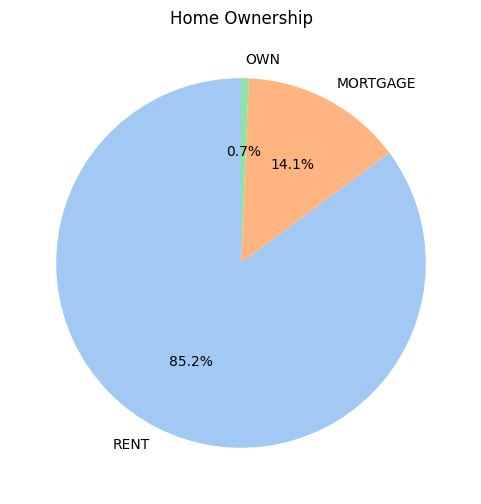

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data
data = [879, 146, 7]
labels = ['RENT', 'MORTGAGE', 'OWN']

# Create the pie chart
plt.figure(figsize=(6, 6))  # Adjust figure size if needed
sns.set_palette('pastel')  # Set color palette
plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Home Ownership')
plt.show()

In [12]:
# Surprisingly there are people with mortgage in this and less of people owning home
# We will look further into it in just some time
# Next up what are the purposes
df_A_grade['loan_intent'].value_counts()

loan_intent
MEDICAL              227
EDUCATION            206
PERSONAL             189
DEBTCONSOLIDATION    184
HOMEIMPROVEMENT      124
VENTURE              102
Name: count, dtype: int64

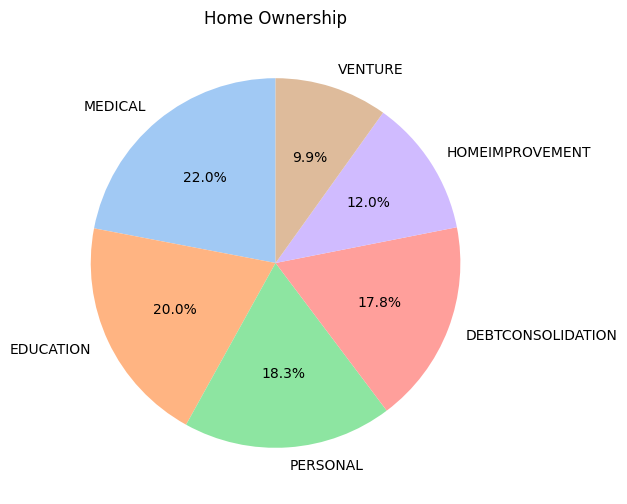

In [13]:
names = ['MEDICAL', 'EDUCATION', 'PERSONAL', 'DEBTCONSOLIDATION', 'HOMEIMPROVEMENT', 'VENTURE']
counts = [227, 206, 189, 184, 124, 102]

# Create the pie chart
plt.figure(figsize=(6, 6))  # Adjust figure size if needed
sns.set_palette('pastel')  # Set color palette
plt.pie(counts, labels=names, autopct='%1.1f%%', startangle=90)
plt.title('Home Ownership')
plt.show()

In [14]:
# Venture seems to be a bit on the lower side
df_A_grade['cb_person_default_on_file'].value_counts()



cb_person_default_on_file
0    1032
Name: count, dtype: int64

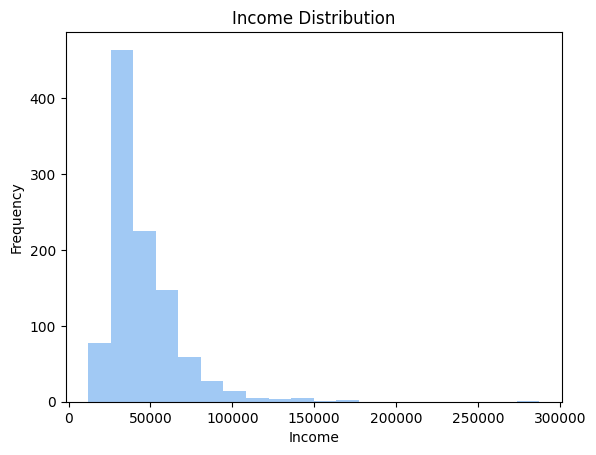

In [15]:
# This is where there is no compromise no defaults
# Let us create histogram of income
# Create the histogram
plt.hist(df_A_grade['person_income'], bins=20)  # Adjust bins as needed
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('Income Distribution')
plt.show()


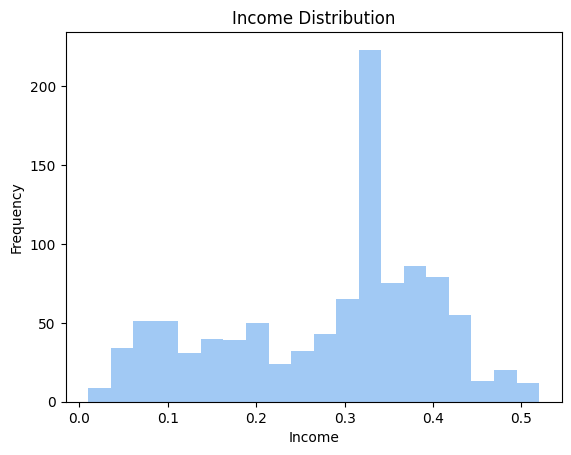

In [16]:
## Surprisingly it includes a lot of people below 50k annual income
# I think that loan percent income is the key here
# This is where there is no compromise no defaults
# Let us create histogram of income
# Create the histogram
plt.hist(df_A_grade['loan_percent_income'], bins=20)  # Adjust bins as needed
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('Income Distribution')
plt.show()

In [17]:
## As expected the range is from 0 to 0.5, with majority being in the 0.3 to 0.4 range
## Now let us check the credit history length
df_A_grade['cb_person_cred_hist_length'].value_counts()

cb_person_cred_hist_length
4     201
2     184
3     177
6      76
8      69
9      63
7      54
5      52
10     48
12     17
13     17
14     16
17     15
16     13
11     12
15      5
27      3
25      2
19      2
28      2
30      1
24      1
21      1
18      1
Name: count, dtype: int64

In [18]:
#Here we see that the person needs to have couple of items in credit history 

df_A_grade['person_emp_length'].value_counts()

# Consideing that most people are in the 20s and 30s this tallies well

person_emp_length
0.0     167
2.0     133
3.0     124
4.0     114
1.0     111
5.0      92
6.0      85
7.0      64
8.0      31
9.0      23
11.0     18
12.0     17
10.0     14
14.0     14
13.0      7
15.0      5
21.0      3
18.0      2
17.0      2
27.0      1
24.0      1
16.0      1
19.0      1
23.0      1
20.0      1
Name: count, dtype: int64

In [19]:
# Now coming back to people with mortgage, I think they will have high income and low
# loan percent income
df_A_mortgage = df_A_grade[df_A_grade['person_home_ownership']=='MORTGAGE']
df_A_mortgage.shape

(146, 13)

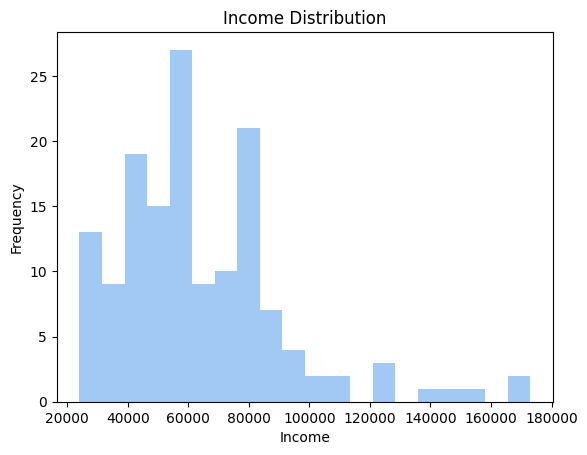

In [20]:
plt.hist(df_A_mortgage['person_income'], bins=20)  # Adjust bins as needed
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('Income Distribution')
plt.show()

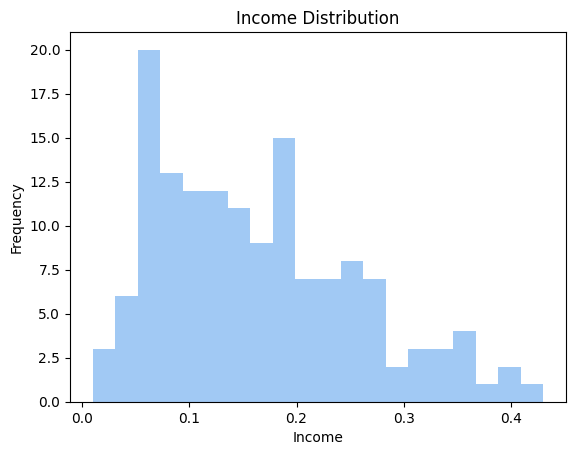

In [21]:
plt.hist(df_A_mortgage['loan_percent_income'], bins=20)  # Adjust bins as needed
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('Income Distribution')
plt.show()

In [22]:
## While the general loan percent income is in the range of 0.3 to 0.4
## In case of people with mortgage the majority is from 0.01 to 0.2

In [23]:
# Let us check people who have rejected A grade loans
df_not_A_grade = df[(df['loan_grade']=='A') & (df['loan_status']==0)] 
df_not_A_grade.shape

(19952, 13)

In [24]:
# Assumptions here would be people will have either defaults
# High loan to income percent
# More house in mortgage
# Let us start with defaults
df_not_A_grade['cb_person_default_on_file'].value_counts()

cb_person_default_on_file
0    19948
1        4
Name: count, dtype: int64

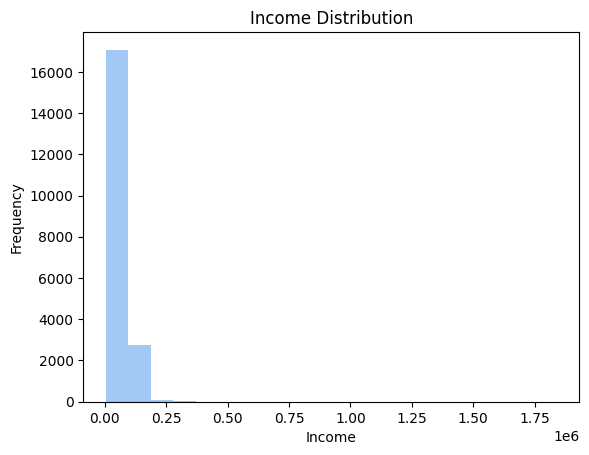

In [25]:
plt.hist(df_not_A_grade['person_income'], bins=20)  # Adjust bins as needed
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('Income Distribution')
plt.show()

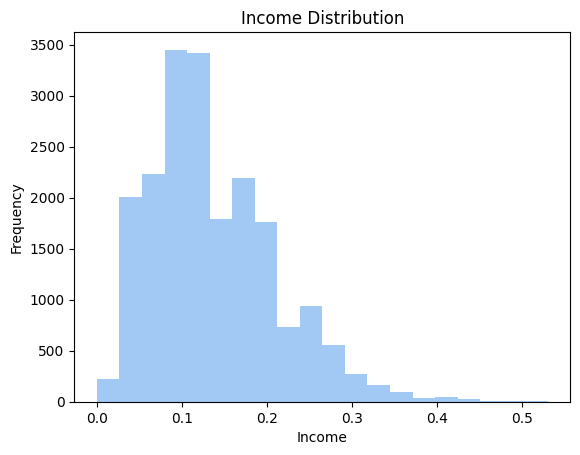

In [26]:
# Very low income is a characteristic feature for them
# As a consequece we might see higher income to loan ratio
plt.hist(df_not_A_grade['loan_percent_income'], bins=20)  # Adjust bins as needed
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('Income Distribution')
plt.show()

In [27]:
average_rates = df.groupby('loan_grade')['cb_person_default_on_file'].mean()
print(average_rates)

## If you have defaulted very less chance for A and B grade loans, hence less applications

loan_grade
A    0.000191
B    0.000294
C    0.499547
D    0.511124
E    0.502478
F    0.543624
G    0.545455
Name: cb_person_default_on_file, dtype: float64


In [28]:
average_below_40 = df[df['person_age'] < 40]['cb_person_default_on_file'].mean()
average_above_40 = df[df['person_age'] >= 40]['cb_person_default_on_file'].mean()

print(f"Average defaults for people below 40: {average_below_40}")
print(f"Average defaults for people above 40: {average_above_40}")

## Higher age means more time to default. Recency of default is not known  

Average defaults for people below 40: 0.14802460501067055
Average defaults for people above 40: 0.1553398058252427


In [29]:
average_rates = df.groupby('loan_intent')['cb_person_default_on_file'].mean()
print(average_rates)

loan_intent
DEBTCONSOLIDATION    0.141575
EDUCATION            0.152310
HOMEIMPROVEMENT      0.171019
MEDICAL              0.145692
PERSONAL             0.147664
VENTURE              0.139247
Name: cb_person_default_on_file, dtype: float64


In [30]:
average_rates = df.groupby('loan_intent')['loan_status'].mean()
print(average_rates)

## Less support for venture and education

loan_intent
DEBTCONSOLIDATION    0.189313
EDUCATION            0.107734
HOMEIMPROVEMENT      0.173726
MEDICAL              0.178251
PERSONAL             0.132788
VENTURE              0.092798
Name: loan_status, dtype: float64


In [31]:


df = X_TRAIN   
average_below_4 = df[df['cb_person_cred_hist_length'] <= 4]['loan_status'].mean()
average_above_4 = df[df['cb_person_cred_hist_length'] > 4]['loan_status'].mean()

print(f"Average loan status for people below 4: {average_below_4}")
print(f"Average loan status for people above 4: {average_above_4}")

## One could attribute that to more time to default

Average loan status for people below 4: 0.14810059190128716
Average loan status for people above 4: 0.13554690424496518


In [32]:

df = X_TRAIN   
average_below_4 = df[df['cb_person_cred_hist_length'] <= 4]['cb_person_default_on_file'].mean()
average_above_4 = df[df['cb_person_cred_hist_length'] > 4]['cb_person_default_on_file'].mean()

print(f"Average default for people below 4: {average_below_4}")
print(f"Average default for people above 4: {average_above_4}")

## surprisingly same

Average default for people below 4: 0.148570354827597
Average default for people above 4: 0.14816201242794041


In [33]:

df = X_TRAIN   
average_below_4 = df[df['person_emp_length'] <= 4]['cb_person_default_on_file'].mean()
average_above_4 = df[df['person_emp_length'] > 4]['cb_person_default_on_file'].mean()

print(f"Average default for people below 4: {average_below_4}")
print(f"Average default for people above 4: {average_above_4}")

## People who have worked more less likely to default

Average default for people below 4: 0.16790123456790124
Average default for people above 4: 0.124953095684803


In [34]:
X_TRAIN['cb_person_default_on_file'] = X_TRAIN['cb_person_default_on_file'].map({'Y': 1, 'N': 0})

X_TEST['cb_person_default_on_file'] = X_TEST['cb_person_default_on_file'].map({'Y': 1, 'N': 0})

In [35]:
df = X_TRAIN   
average_below_4 = df[df['person_emp_length'] <= 4]['loan_status'].mean()
average_above_4 = df[df['person_emp_length'] > 4]['loan_status'].mean()

print(f"Average loan status for people below 4: {average_below_4}")
print(f"Average loan status for people above 4: {average_above_4}")

## And yet less likely to get loans

Average loan status for people below 4: 0.17543366150961087
Average loan status for people above 4: 0.10270168855534709


In [36]:
# import seaborn as sns
# import pandas as pd
# import matplotlib.pyplot as plt

# # # Assuming your DataFrame is called 'df' and has numerical features and 'loan_status'
# # numerical_features = X_TRAIN.select_dtypes(['int64', 'float64']).columns.to_list()  # Select numerical columns

# # # Create scatter plots for all combinations
# # sns.pairplot(X_TRAIN, vars=numerical_features, hue='loan_status')
# # plt.show()

In [37]:
## As loan percent income increases, so does chance of approval
df = X_TRAIN   
average_below_4 = df[df['loan_percent_income'] <= 0.4]['loan_status'].mean()
average_above_4 = df[df['loan_percent_income'] > 0.4]['loan_status'].mean()

print(f"Average loan status for people below .4: {average_below_4}")
print(f"Average loan status for people above .4: {average_above_4}")

Average loan status for people below .4: 0.13287972437195936
Average loan status for people above .4: 0.7618510158013544


In [38]:
df = X_TRAIN   
average_below_50 = df[df['person_income'] <= 50000]['loan_status'].mean()
average_above_50 = df[df['person_income'] > 50000]['loan_status'].mean()

print(f"Average loan status for people below 50000: {average_below_50}")
print(f"Average loan status for people above 50000: {average_above_50}")
df[df['person_income'] >= 50000]['loan_status'].count()

average_below_50 = df[df['person_income'] <= 50000]['loan_amnt'].mean()
average_above_50 = df[df['person_income'] > 50000]['loan_amnt'].mean()
print(f"Average loan amnt for people below 50000: {average_below_50}")
print(f"Average loan amnt for people above 50000: {average_above_50}")


average_below_50 = df[df['person_income'] <= 50000]['cb_person_default_on_file'].mean()
average_above_50 = df[df['person_income'] > 50000]['cb_person_default_on_file'].mean()
print(f"Average default for people below 50000: {average_below_50}")
print(f"Average default amnt for people above 50000: {average_above_50}")

# People with higher income has very less chance of getting a loan
# The loan amount of these people is on a higher side
# people below 50 has more defaults as well

Average loan status for people below 50000: 0.21792728792310906
Average loan status for people above 50000: 0.0903067838110327
Average loan amnt for people below 50000: 7106.1544086920185
Average loan amnt for people above 50000: 10673.003802390896
Average default for people below 50000: nan
Average default amnt for people above 50000: nan
